# SD212: Graph mining
## Partial solution to Lab 2: Graph structure

In this lab, you will learn to:
* plot the degree distribution and observe the [power-law](https://en.wikipedia.org/wiki/Power_law#Power-law_probability_distributions),
* estimate the [diameter](https://en.wikipedia.org/wiki/Distance_(graph_theory)) of a graph and observe the [small-world](https://en.wikipedia.org/wiki/Small-world_network) property,
* estimate the [clustering coefficient](https://en.wikipedia.org/wiki/Clustering_coefficient) of a graph.

## Import

In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from sknetwork.data import load_netset, erdos_renyie, cyclic_graph, linear_graph
from sknetwork.utils import bipartite2undirected

## Data

We will work on the following graphs (see the [NetSets](https://graphs.telecom-paristech.fr/Home_page.html#netsets-section) collection for details):
* Openflights (graph)
* WikiVitals (digraph)
* Cinema (bigraph)

In [4]:
openflights = load_netset('openflights')

In [5]:
# focus on degrees, not weights
adjacency = (openflights.adjacency > 0)

In [6]:
wikivitals = load_netset('wikivitals')

In [7]:
cinema = load_netset('cinema')

## 1. Power law

We first focus on the power law degree distribution.

We consider the empirical distributions of:
* degrees in the Openflights graph,
* out-degrees and in-degrees in the WikiVitals graph.

## To do

For each of these distributions:
* Compute the [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) and compare it to that of a Poisson distribution with the same mean.
* Plot the [tail distribution](https://en.wikipedia.org/wiki/Cumulative_distribution_function#Complementary_cumulative_distribution_function_(tail_distribution)) in log-log scale and compare it to that of an equivalent [Erdos-Rényi](https://en.wikipedia.org/wiki/Erdős–Rényi_model) graph (same number of nodes, same average degree).
* Conclude: do you consider that this is a power law?

In [8]:
adjacency = wikivitals.adjacency

In [9]:
n = adjacency.shape[0]

In [10]:
# in-degrees
degrees = adjacency.T.dot(np.ones(n))

In [11]:
E= np.mean(degrees)

In [12]:
V =np.std(degrees)**2

In [13]:
alpha=(E**2+E*V)/(V*(E-2))
km = (alpha-1)/alpha*E

In [14]:
np.std(degrees) / np.mean(degrees)

1.3553811414388752

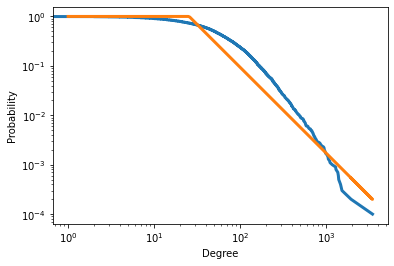

In [18]:
plt.loglog(np.sort(degrees), 1 - np.arange(n) / n, lw = 3)
plt.loglog(x,y, lw = 3)
_ = plt.xlabel('Degree')
_ = plt.ylabel('Probability')

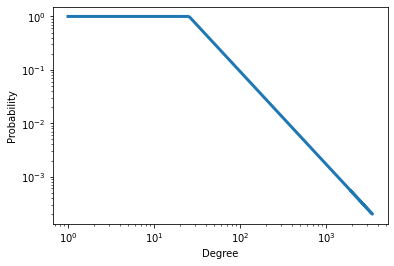

In [17]:
x = np.array(list(set(np.sort(degrees))))
x = x[1:]
y = (km/x)**alpha2
y[x<km]=1
plt.loglog(x,y, lw = 3)
_ = plt.xlabel('Degree')
_ = plt.ylabel('Probability')

In [15]:
# aqui hemo usado la mediana para el calculo de km, referencia wikipedia
km=np.median(degrees)/2**(1/alpha)
km

25.55966264734155

In [16]:
# este es el valor de alpha k obtenemos con el uno de la esperanza y la mediana
alpha2 =1.736

## 2. Small-world

You will now make a few experiments highlighting the small-world property.

## To do

* Complete the following function computing the distances from any given node in number of hops.
* Compare it to the function `shortest_path` of SciPy.

In [ ]:
def get_distances(adjacency: sparse.csr_matrix, source: int) -> np.ndarray:
    '''Get distances from a source node in number of hops.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    source:
        Source node
    
    Returns
    -------
    distances:
        Vector of distances.
    '''
    n = adjacency.shape[0]
    distances = np.inf * np.ones(n)
    distances[source] = 0
    reached = np.zeros(n).astype(bool)
    reached[source] = True
    change = True
    t = 0
    while change:
        t += 1
        reached = adjacency.T.dot(reached)
        new_nodes = np.argwhere((distances == np.inf) * reached).ravel()
        distances[new_nodes] = t
        change = len(new_nodes)
    return distances

In [ ]:
adjacency = openflights.adjacency > 0

In [ ]:
distances = get_distances(adjacency, 0)

In [ ]:
distances_scipy = shortest_path(adjacency, indices=[0])[0]

In [ ]:
np.array_equal(distances, distances_scipy)

## To do

* Which fraction of the airports can be reached from **Paris Charles de Gaulle** in 1, 2, 3 flights?
* Which fraction of the articles can be reached from **Paris** in 1, 2, 3 clicks on Wikipedia Vitals?

In [ ]:
names = openflights.names

In [ ]:
cdg = {i:name for i, name in enumerate(names) if 'Gaulle' in name}

In [ ]:
cdg

## To do

The following function estimates the [diameter](https://en.wikipedia.org/wiki/Distance_(graph_theory)) of a graph.

* Adapt this function so that it returns a path of maximum length.
* Give a path of **length 12** in Openflights (with the airport names).
* Give a path of **length 6** in WikiVitals (with the names of the articles).

In [ ]:
def estimate_diameter(adjacency: sparse.csr_matrix, n_samples=100) -> int:
    '''Estimate the diameter of a graph.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    n_samples:
        Number of samples.
    
    Returns
    -------
    diameter:
        Estimation of the diameter. 
    '''    
    n = adjacency.shape[0]
    nodes = np.random.choice(n, size=n_samples)
    distances = shortest_path(adjacency.T, indices=nodes)
    nodes_far = np.where(np.isinf(distances), -1, distances).argmax(axis=1)    
    distances = shortest_path(adjacency, indices=nodes_far)
    diameter = np.where(np.isinf(distances), -1, distances).max()
    return int(diameter)

In [ ]:
def estimate_path(adjacency: sparse.csr_matrix, n_samples=100) -> list:
    '''Return a path of length equal to the estimated diameter of a graph.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    n_samples:
        Number of samples.
    
    Returns
    -------
    path:
        List of nodes. 
    '''    
    n = adjacency.shape[0]
    nodes = np.random.choice(n, size=n_samples)
    distances = shortest_path(adjacency.T, indices=nodes)
    sources = np.where(np.isinf(distances), -1, distances).argmax(axis=1)    
    distances, preds = shortest_path(adjacency, indices=sources, return_predecessors=True)
    # best source
    k = np.where(np.isinf(distances), -1, distances).max(axis=1).argmax()
    source = sources[k]
    pred = preds[k]
    distance = distances[k]
    # furthest node from best source
    dest = np.where(np.isinf(distance), -1, distance).argmax()
    # backward path from dest to source
    path = []
    while dest != source:
        path.append(dest)
        dest = pred[dest]
    return list(np.flip(path))

In [ ]:
adjacency = wikivitals.adjacency

In [ ]:
path = estimate_path(adjacency)

In [ ]:
len(path)

In [ ]:
names = wikivitals.names

In [ ]:
for i in path:
    print(i, names[i])

## To do

* Compute the [Bacon number](https://fr.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon) of all actors (**without** building the co-starring actor graph).
* Plot the corresponding histogram.

In [ ]:
biadjacency = cinema.biadjacency

In [ ]:
biadjacency

In [ ]:
# corresponding graph with a mix of movies and actors (movies first)
adjacency = bipartite2undirected(biadjacency)

## 3. Clustering coefficient

You will now learn to estimate the clustering coefficient of a graph.

## To do


* Complete the following function to estimate the clustering coefficient of a graph.
* Test it on a triangle and  a line.
* Compute the clustering coefficient of Openflights and WikiVitals (seen as an undirected graph).

**Hint:** A triangle is... a cycle of length 3

In [ ]:
def clustering_coefficient(adjacency: sparse.csr_matrix, n_samples: int = 500) -> float:
    '''Get the clustering coefficient of a graph.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    
    Returns
    -------
    clustering_coef:
        Clustering coefficient.
    '''
    clustering_coef = 0
    
    n = adjacency.shape[0]
    if n_samples < n:
        nodes = np.random.choice(n, size=n_samples, replace=False)
    else:
        nodes = np.arange(n)
        
    # to be completed
    return clustering_coef

In [ ]:
triangle = cyclic_graph(3)

In [ ]:
line = linear_graph(5)